In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from __future__ import division
from IPython.display import Image
from deltasigma import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
np.set_printoptions(suppress=True, precision=3)

In [4]:
order = 8
osr = 32
nlev = 2
f0 = 0.125
Hinf = 1.5
form = 'CRFB'

In [5]:
ntf = synthesizeNTF(order, osr, 2, Hinf, f0)            # Optimized zero placement
print("Synthesized a %d-order NTF, with roots:\n" % order)
print(" Zeros:\t\t\t Poles:")
for z, p in zip(ntf[0], ntf[1]):
    print("(%f, %fj)\t(%f, %fj)" % (np.real(z), np.imag(z), np.real(p), np.imag(p)))
print("")

Synthesized a 8-order NTF, with roots:

 Zeros:			 Poles:
(0.735825, 0.677171j)	(0.574412, -0.755247j)
(0.735825, -0.677171j)	(0.574412, 0.755247j)
(0.707107, 0.707107j)	(0.576806, -0.657630j)
(0.707107, -0.707107j)	(0.576806, 0.657630j)
(0.707107, 0.707107j)	(0.637688, -0.578575j)
(0.707107, -0.707107j)	(0.637688, 0.578575j)
(0.677171, 0.735825j)	(0.751098, -0.551585j)
(0.677171, -0.735825j)	(0.751098, 0.551585j)



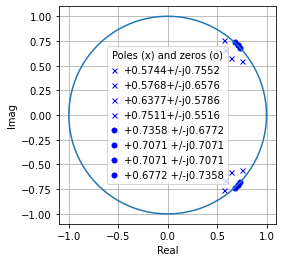

In [6]:
plotPZ(ntf, showlist=True)
a, g, b, c = realizeNTF(ntf, form)

In [7]:
Image(url='http://python-deltasigma.readthedocs.org/en/latest/_images/CRFB.png', retina=True)

In [7]:
b = np.hstack(( # Use a single feed-in for the input
               np.atleast_1d(b[0]),
               np.zeros((b.shape[0] - 1, ))
             ))
ABCD = stuffABCD(a, g, b, c, form)
print("ABCD Matrix:")
print(ABCD)

ABCD Matrix:
[[ 1.    -0.528  0.     0.     0.     0.     0.     0.     0.001 -0.001]
 [ 1.     0.472  0.     0.     0.     0.     0.     0.     0.001  0.001]
 [ 0.     1.     1.    -0.586  0.     0.     0.     0.     0.     0.008]
 [ 0.     1.     1.     0.414  0.     0.     0.     0.     0.     0.028]
 [ 0.     0.     0.     1.     1.    -0.586  0.     0.     0.     0.126]
 [ 0.     0.     0.     1.     1.     0.414  0.     0.     0.     0.048]
 [ 0.     0.     0.     0.     0.     1.     1.    -0.646  0.    -0.018]
 [ 0.     0.     0.     0.     0.     1.     1.     0.354  0.    -0.574]
 [ 0.     0.     0.     0.     0.     0.     0.     1.     0.     0.   ]]


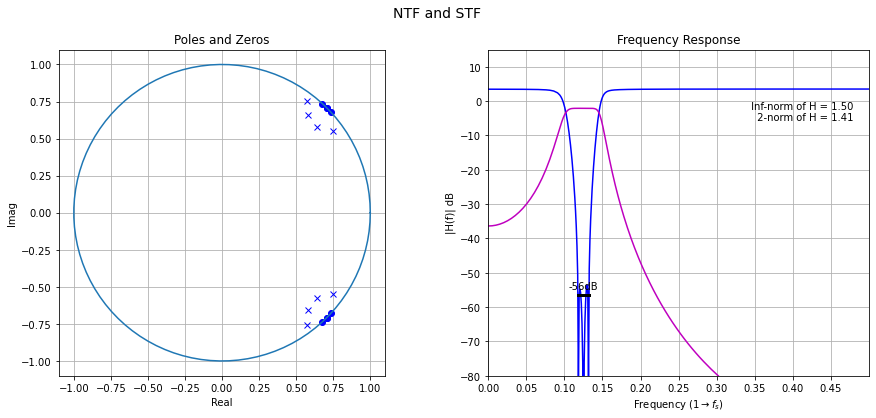

In [8]:
DocumentNTF(ABCD, osr, f0)
f = plt.gcf()
f.set_size_inches((15, 6))

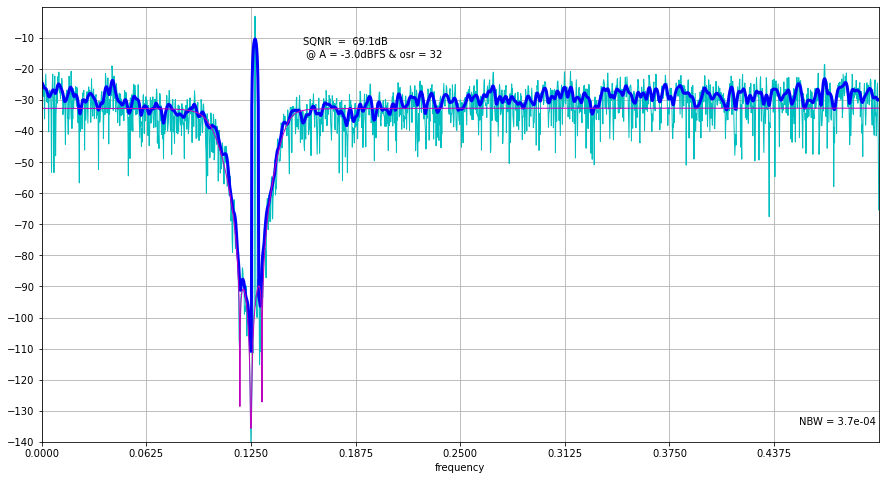

In [9]:
plt.figure(figsize=(15,8))
PlotExampleSpectrum(ntf, M=1, osr=osr, f0=f0)

In [10]:
snr, amp = simulateSNR(ntf, osr, None, f0, nlev)

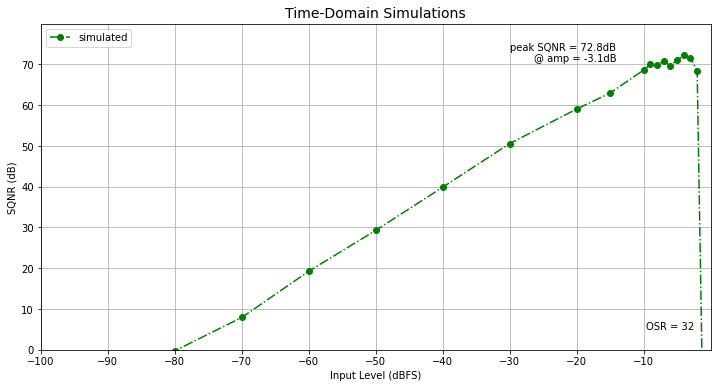

In [12]:
plt.figure(figsize=(15,8))
if nlev == 2 and f0 == 0.:
    snr_pred, amp_pred, k0, k1, se = predictSNR(ntf, osr)
    plt.plot(amp_pred, snr_pred, '-', label='predicted')
plt.plot(amp, snr,'o-.g', label='simulated')
plt.xlabel('Input Level (dBFS)')
plt.ylabel('SQNR (dB)')
peak_snr, peak_amp = peakSNR(snr, amp)
msg = 'peak SQNR = %4.1fdB  \n@ amp = %4.1fdB  ' % (peak_snr, peak_amp)
plt.text(peak_amp-10,peak_snr,msg, horizontalalignment='right', verticalalignment='center');
msg = 'OSR = %d ' % osr
plt.text(-2, 5, msg, horizontalalignment='right');
figureMagic([-100, 0], 10, None, [0, 80], 10, None, [12, 6], 'Time-Domain Simulations')
plt.legend(loc=2);

In [13]:
 # Dynamic range scaling
print('Doing dynamic range scaling... ')
ABCD0 = ABCD.copy()
ABCD, umax, S = scaleABCD(ABCD0, nlev, f0)
#a, g, b, c = mapABCD(ABCD,form);
print('Done.')
print("Maximum input magnitude: %.3f" % umax)

Doing dynamic range scaling... 
Done.
Maximum input magnitude: 0.867


In [14]:
print('Verifying dynamic range scaling... ')
u = np.linspace(0, 0.95*umax, 30)
N = 10000
N0 = 50
test_tone = np.cos(2*np.pi*f0*np.arange(N))
test_tone[:N0] = test_tone[:N0]*(0.5 - 0.5*np.cos(2*np.pi/N0*np.arange(N0)))
maxima = np.zeros((order, u.shape[0]))
for i in np.arange(u.shape[0]):
    ui = u[i]
    v, xn, xmax, y = simulateDSM(ui*test_tone, ABCD, nlev)
    maxima[:, i] = xmax[:, 0]
    if (xmax > 100).any(): 
        print('Warning, umax from scaleABCD was too high.')
        umax = ui
        u = u[:i]
        maxima = maxima[:, :i]
        break
print('Done.')
print("Maximum DC input level: %.3f" % umax)

Verifying dynamic range scaling... 
Done.
Maximum DC input level: 0.867


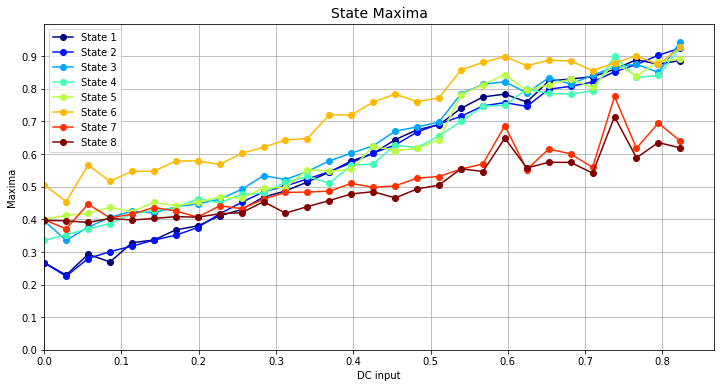

In [15]:
colors = plt.get_cmap('jet')(np.linspace(0, 1.0, order))
for i in range(order):
    plt.plot(u, maxima[i,:], 'o-', color=colors[i], label='State %d' % (i+1))
plt.grid(True)
figureMagic([0, umax], None, None, [0, 1] , 0.1, 2, [12, 6], 'State Maxima')
plt.xlabel('DC input')
plt.ylabel('Maxima')
plt.legend(loc='best');

In [16]:
a, g, b, c = mapABCD(ABCD, form)

In [17]:
adc = {
       'order':order,
       'osr':osr,
       'nlev':nlev,
       'f0':f0,
       'ntf':ntf,
       'ABCD':ABCD,
       'umax':umax,
       'peak_snr':peak_snr,
       'form':form,
       'coefficients':{
                       'a':a,
                       'g':g,
                       'b':b,
                       'c':c
                      }
      }

In [18]:
print("Final ADC coefficients:")
print("  %s\n   %s" % ('a', adc['coefficients']['a']))
print("  %s\n   %s" % ('g', adc['coefficients']['g']))
print("  %s\n   %s" % ('b', adc['coefficients']['b']))
print("  %s\n   %s" % ('c', adc['coefficients']['c']))

Final ADC coefficients:
  a
   [ 0.084 -0.105 -0.064 -0.133 -0.255  0.098  0.008  0.169]
  g
   [0.72  0.731 0.944 0.908]
  b
   [0.084 0.    0.    0.    0.    0.    0.    0.    0.   ]
  c
   [0.734 0.158 0.801 0.309 0.621 0.339 0.711 3.297]


### System version information

In [19]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma

AttributeError: module 'cgi' has no attribute 'escape'

Software versions
Python 3.8.5 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.18.1
OS Windows 10 10.0.19041 SP0
numpy 1.19.1
scipy 1.5.0
matplotlib 3.3.1
deltasigma 0.2.2
Fri Sep 18 15:14:27 2020 東京 (標準時)